# Wall-driven flow between parallel plates

## Overview

### Questions

- How do I setup and confine an MPCD fluid between parallel plates?
- How do I measure a flow field in particle-based simulations?
- How do different bounce-back schemes affect flow?
- How does grid shifting change the behavior of the MPCD algorithm?

### Objectives

- Demonstrate how to initialize MPCD particles between parallel plates using a
  **Snapshot**.
- Show how to include a confining **Geometry** in both the MPCD streaming and
  collision steps.
- Demonstrate how to simulate and measure wall-driven shear flow.
- Explain the difference between slip and no-slip boundary conditions.
- Explain the importance of grid shifting (Galilean invariance) in the MPCD
  algorithm.

## Boilerplate code

In [1]:
import hoomd
import hoomd.azplugins
import hoomd.mpcd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Background

Wall-driven flow is created when a fluid is in contact with a moving surface. We
typically assume that the fluid will have "no slip" relative to the surface such
that it is required to move with the same velocity.

Let's suppose we have parallel plates at $y = \pm H$ with normals in the *y*
direction. We will make these walls move in opposite directions, with a fixed
velocity $U$ in $+x$ on the "top" wall and $-U$ in $-x$ on the "bottom" wall.
The motion of the walls should generate a flow in only the *x* direction that
depends only on *y*. Assuming the MPCD particles act as an incompressible
Newtonian fluid, the momentum balance that governs the flow, which is a
second-order ordinary differential equation, is:

$$
\mu \frac{{\rm d}^2 u_x}{{\rm d}y^2} = 0
$$

where $\mu$ is the dynamic viscosity and $u_x$ is the velocity in the *x*
direction. The general solution to this differential equation is:

$$
u_x = c_1 y + c_2
$$

where $c_1$ and $c_2$ are unknown coefficients. No slip at the boundaries means
that $u_x(\pm H) = \pm U$, so applying these conditions and solving for $c_1$
and $c_2$ gives:

$$
u_x(y) = U \frac{y}{H}, \quad -H \le y \le H
$$

This type of flow is sometimes called simple shear or planar Couette flow.
Let's see if MPCD produces this result!

## Initialization

The MPCD particles will be initialized using a `Snapshot`. We will place the
particles between two [ParallelPlates](https://hoomd-blue.readthedocs.io/en/stable/hoomd/mpcd/geometry/parallelplates.html).
with separation distance $2 H = 20\ell$. The plates are infinite in the *x* and
*z* directions, so periodic boundaries will be used in these directions. We
choose the extent in the periodic directions to be $L = 25\ell$.

The simulation box will need to be padded in the *y* direction to account for
the collision cells wrapping through the *y* periodic boundary. The collision
cells have unit length by default, so a a padding of $4\ell$ (2 cells on each
side) should be sufficient.

In [2]:
H = 10
L = 25
padding = 4
snapshot = hoomd.Snapshot()
snapshot.configuration.box = [L, 2 * H + padding, L, 0, 0, 0]

The MPCD particle positions will be randomly drawn between the parallel plates
at a target number density $\rho = 5/\ell^3$. All particles will use the default
typeid (0), which we will call "A", and default mass (1). The number of
particles *N* can be computed using the density, $N = \rho V$ where $V = 2 H
L^2$ is the volume between the parallel plates. Note that this volume is **not**
the same as the total volume of the simulation box because we don't want to put
particles outside the walls. The particle velocities also need to be initialized
from the Maxwell-Boltzmann distribution with $T = \varepsilon/k_{\rm B}$.

In [3]:
mass = 1
density = 5
kT = 1
rng = numpy.random.default_rng(seed=42)

snapshot.mpcd.types = ["A"]
snapshot.mpcd.N = int(density * (2 * H) * L**2)
snapshot.mpcd.mass = mass
snapshot.mpcd.position[:] = [0.5 * L, H, 0.5 * L] * rng.uniform(
    low=-1, high=1, size=(snapshot.mpcd.N, 3)
)

velocity = rng.normal(0.0, numpy.sqrt(kT / mass), (snapshot.mpcd.N, 3))
velocity -= numpy.mean(velocity, axis=0)
snapshot.mpcd.velocity[:] = velocity

The simulation can now be initialized from the snapshot.

In [4]:
simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
simulation.create_state_from_snapshot(snapshot)

## Configuring the MPCD integrator

We now need to setup an MPCD integrator for our particles that will respect the
walls we have put in place. We will use the SRD collision with timestep
$\Delta t = 0.1\,\tau$, collision angle $\alpha = 130^\circ$, and a thermostat
to maintain constant temperature.

In [5]:
integrator = hoomd.mpcd.Integrator(dt=0.1)
integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=1, angle=130, kT=kT
)
integrator.mpcd_particle_sorter = hoomd.mpcd.tune.ParticleSorter(
    trigger=20 * integrator.collision_method.period
)
simulation.operations.integrator = integrator

This looks the same as for our bulk simulations! The first difference is that
now we need to setup the streaming method to account for the walls. First,
we create a **ParallelPlates** object to represent our boundaries.

In [6]:
U = 0.5
plates = hoomd.mpcd.geometry.ParallelPlates(separation=2 * H, speed=U, no_slip=True)

Now, we create a bounce-back integrator that will enforce the geometry on the
motion of the MPCD particles during streaming. Bounce back refers to the
approach used to change the particle velocities when they hit the boundary
during streaming. For no-slip boundary conditions, the velocity relative to the
wall velocity is reversed.

In [7]:
integrator.streaming_method = hoomd.mpcd.stream.BounceBack(
    period=1, geometry=plates
)

In addition to using a bounce-back streaming method, we also need to add a
[GeometryFiller](https://hoomd-blue.readthedocs.io/en/stable/hoomd/mpcd/fill/geometryfiller.html)
to add virtual particles to the collision cells that are sliced by the solid
boundary. This filler helps prevent underfilling of these cells, which can
produce undesirable results near these boundaries.

In [8]:
filler = hoomd.mpcd.fill.GeometryFiller(
    type="A", density=density, kT=kT, geometry=plates
)
integrator.virtual_particle_fillers.append(filler)

## Particle distribution

Let's check to make sure our simulation was setup correctly! First, we can use
[BounceBack.check_mpcd_particles](https://hoomd-blue.readthedocs.io/en/stable/hoomd/mpcd/stream/bounceback.html#hoomd.mpcd.stream.BounceBack.check_mpcd_particles)
to make sure we placed all our particles correctly to start. We need to do a
`run(0)` to make sure everything is initialized first.

In [9]:
simulation.run(0)
print(integrator.streaming_method.check_mpcd_particles())

True


Now, let's run a couple steps and check again:

In [10]:
simulation.run(10)
print(integrator.streaming_method.check_mpcd_particles())

True


If we want to be really sure ourselves, we can also check the *y* coordinates of
all the MPCD particles:

In [11]:
snapshot = simulation.state.get_snapshot()
y = snapshot.mpcd.position[:, 1]
print(numpy.all((y >= -H) & (y <= H)))

True


## Velocity field

### Warmup

Now that we are sure we have the particles setup correctly, we need to run the
simulation long enough to establish the steady-state flow field. We started our
particles from rest, and it takes a finite amount of time for momentum to
propagate through the MPCD particles. We can monitor the kinetic energy of the
particles in the flow direction as a proxy for when the flow has developed.

HOOMD does not currently compute the kinetic energy of MPCD particles for us,
so we need to do it ourselves. We'll use a sequence of short runs, calculating
the kinetic energy in between.

In [12]:
num_samples = 100
num_steps_per_sample = 10
times = numpy.zeros(num_samples, dtype=int)
kinetic_energy = numpy.zeros(num_samples)
for i in range(num_samples):
    simulation.run(num_steps_per_sample)

    snapshot = simulation.state.get_snapshot()
    times[i] = simulation.timestep * integrator.dt
    kinetic_energy[i] = (
        0.5 * snapshot.mpcd.mass * numpy.sum(snapshot.mpcd.velocity[:, 0]**2)
    )

We see that the kinetic energy is leveling off by the end of this "warmup"
period, so we are now ready to make some measurements.

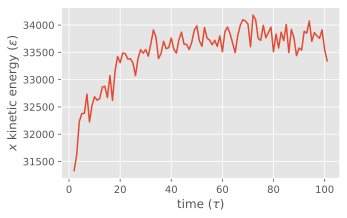

In [13]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(times, kinetic_energy)
ax.set_xlabel(r"time ($\tau$)")
ax.set_ylabel(r"$x$ kinetic energy ($\varepsilon$)")
fig

*Question*: what do you expect the kinetic energy to be at the start of the
simulation? At steady-state? (Note: this requires statistical mechanics to
answer.)

### Production

We are now ready to sample the velocity field. We can do this by binning the
particles based on their position, then averaging the velocities of particles
in each bin. If we repeat this enough times, we will get a measured *average*
velocity field representing the flow. You can implement this procedure yourself
using NumPy, but it can be slow due to the large number of MPCD particles.
We will use the [CartesianVelocityFieldCompute](https://azplugins.readthedocs.io/en/stable/module-azplugins-compute.html#hoomd.azplugins.compute.CartesianVelocityFieldCompute)
from azplugins to do the same calculation. This compute does the binning on
the native particle data using the current device. You can then time-average the
result of this calculation in Python.

To configure this compute, we need to choose a size for our bins. Let's use a
bin spacing of $\Delta y = 0.5\ell$ as a first guess. The number of bins we
need to cover the space between the walls is then $2H / \Delta y$. We don't
want to bin in the *x* or *z* directions, so we tell this compute to ignore
those directions (and average over them) by setting the number of bins to zero
for each.

In [14]:
bin_size = 0.5
num_bins = numpy.round((2 * H) / bin_size).astype(int)
velocity_field = hoomd.azplugins.compute.CartesianVelocityFieldCompute(
    num_bins=(0, num_bins, 0),
    lower_bounds=(0, -H, 0),
    upper_bounds=(0, H, 0),
    include_mpcd_particles=True
)
simulation.operations.computes.append(velocity_field)

Now, we can run another sequence of simulations to compute the average velocity
field!

In [15]:
num_samples = 500
num_steps_per_sample = 10
for i in range(num_samples):
    simulation.run(num_steps_per_sample)

    # size the array the first time
    if i == 0:
        avg_velocity_field = numpy.zeros(velocity_field.velocities.shape)

    # accumulate x velocity
    avg_velocity_field += velocity_field.velocities
avg_velocity_field /= num_samples

Let's look at a plot of all 3 components of the velocity as a function of *y*.
We expect $u_y$ and $u_z$ to both be zero, but $u_x$ should follow the expected
form. We see that the simulations appear to be pretty close to expectations!

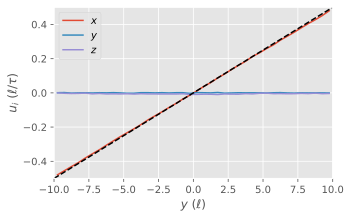

In [16]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()

# simulated flow field
ax.plot(velocity_field.coordinates, avg_velocity_field, label=["$x$", "$y$", "$z$"])

# theoretical flow field
y_theory = numpy.linspace(-H, H)
u_theory = U * y_theory / H
ax.plot(y_theory, u_theory, "k--")

ax.set_xlabel(r"$y$ ($\ell$)")
ax.set_xlim([-H, H])
ax.set_ylabel(r"$u_i$ ($\ell/\tau$)")
ax.set_ylim([-U, U])
ax.legend()
fig

## Grid shifting

When the particle mean free path (proportional to collision time) is short
compared to the size of a collision cell, it is necessary to randomly shift the
MPCD collision cells. The consequences of not doing so are especially apparent
in flow simulations! Let's demonstrate. First, we disable grid shifting (on by
default in HOOMD) and run for another warm up period.

In [17]:
simulation.operations.integrator.cell_list.shift = False
simulation.run(1_000)

Now, we repeat the sampling of the flow field.

In [18]:
num_samples = 500
num_steps_per_sample = 10
for i in range(num_samples):
    simulation.run(num_steps_per_sample)

    # size the array the first time
    if i == 0:
        avg_velocity_field = numpy.zeros(velocity_field.velocities.shape)

    # accumulate x velocity
    avg_velocity_field += velocity_field.velocities
avg_velocity_field /= num_samples

Let's look at $u_x(y)$ again. Instead of being linear, it now looks like a
staircase! The size of the steps is related to the size of the collision cells.
This unphysical result is one consequence of breaking what is called
[Galilean invariance](https://en.wikipedia.org/wiki/Galilean_invariance) in
Newtownian mechanics!

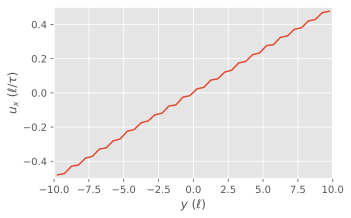

In [19]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()

ax.plot(velocity_field.coordinates, avg_velocity_field[:, 0])

ax.set_xlabel(r"$y$ ($\ell$)")
ax.set_xlim([-H, H])
ax.set_ylabel(r"$u_x$ ($\ell/\tau$)")
ax.set_ylim([-U, U])
fig

## Additional activities

1. Fit the simulated velocity field with no-slip boundary conditions and grid
   shifting enabled. What is its slope, and how close is it to theoretical
   expectations? What might be the cause of any differences?
2. What happens to the velocity field if you remove the virtual particle filler?
3. What happens to the velocity field if you switch to slip boundary conditions
   and why?
4. What happens to the velocity field you measure if you increase or decrease
   the bin size? How would you select a bin size? What are the tradeoffs?
